In [1]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
from concurrent.futures import ThreadPoolExecutor
import time
import csv
from selenium import webdriver
from selenium.common.exceptions import NoSuchElementException
from selenium.common.exceptions import StaleElementReferenceException
firefox_profile = webdriver.FirefoxProfile()
firefox_profile.set_preference('permissions.default.image', 2)
firefox_profile.set_preference('dom.ipc.plugins.enabled.libflashplayer.so', 'false')
driver = webdriver.Firefox(firefox_profile=firefox_profile,executable_path=r"geckodriver")


In [2]:
class rl_product:
    def __init__(self, category, subcategory,title,brand,country,url):
        self.category = category
        self.subcategory = subcategory
        self.title = title
        self.brand = brand
        self.country = country
        self.url = url
    def to_dict(self):
        return {
            'Category': self.category,
            'Subcategory': self.subcategory,
            'Title': self.title,
            'Brand': self.brand,
            'Country': self.country,
            'Url of Product': self.url 
        }

In [3]:
df = pd.DataFrame(columns=['Category','Subcategory','Title','Brand','Country','Url of Product'])
start = time.time()
driver.get('https://contentservice.kz/produkty-pitaniya-napitki-kz/')
page1 = driver.page_source
lxml = BeautifulSoup(page1, "lxml")
brands = {}
for li in lxml.find('ul',class_ = 'link-list link-list_md').find_all('a'):
    driver.get('https://contentservice.kz/'+ str(li['href']))
    inner_pages = driver.page_source
    lxml2 = BeautifulSoup(inner_pages, "lxml")
    category = str(li.find(text=True, recursive=False))
    for li in lxml2.find('ul',class_ = 'link-list link-list_md').find_all('a'):
        driver.get('https://contentservice.kz/'+ str(li['href']))
        inner_inner_pages = driver.page_source
        lxml3 = BeautifulSoup(inner_inner_pages, "lxml")
        subcategory = str(li.find(text=True, recursive=False))
        while True:
            try:
                load_next = driver.find_element_by_class_name('category-products-loadmore')
                load_next.click()
                time.sleep(0.1)
            except NoSuchElementException:
                break
            except StaleElementReferenceException:
                pass
        #re-render page
        inner_inner_pages = driver.page_source
        lxml3 = BeautifulSoup(inner_inner_pages, "lxml")
        products = lxml3.find('div',class_='catalog__grid-view').find_all('a',class_='link-gray')
        rl_products = []
        for product in products:
            brand = product.find('span').text
            if (brand) not in brands:
                product_desc = BeautifulSoup((requests.get(('https://contentservice.kz'+product['href'])).text),"lxml")
                country = product_desc.find('span', class_='flag')
                try:
                    brands[brand] = country['title']
                except:
                    brands[brand] = None
                    
            rl_products.append(rl_product(category,subcategory,product.text,brand,brands[brand],('https://contentservice.kz' + product['href'])))
        df2 = pd.DataFrame([prdct.to_dict() for prdct in rl_products])
        df = df.append(df2) 
print('time scraped:', time.time()-start, 'seconds')

time scraped: 788.1797206401825 seconds


In [4]:
brands

{'Zeren': 'KZ',
 'Kokshe': 'KZ',
 'Nәtige': 'KZ',
 'Активиа': 'RU',
 'Danone': 'KZ',
 'Bio Max': 'RU',
 'Эмиль': 'KZ',
 'Чудо': 'RU',
 'Epica': 'RU',
 'Ehrmann': 'RU',
 'Food Master': 'KZ',
 'Растишка': 'KZ',
 'Actimel': 'RU',
 'Campina': 'RU',
 'Услада': 'RU',
 'Даниссимо': 'RU',
 'Био Баланс': 'KZ',
 'No Brand': 'KZ',
 'Агуша': 'RU',
 'Имунеле': 'RU',
 'Актуаль': 'RU',
 'Amiran': 'KZ',
 'Adal': 'KZ',
 'Умут и Ко': 'KG',
 'Lactis': 'KZ',
 'АЯ': 'KZ',
 'Текели': 'KZ',
 'Кефирные традиции': 'KZ',
 'Околица': 'KZ',
 'Свежее утро': 'KZ',
 'Брест-Литовск': 'BY',
 '': 'KZ',
 'Достойный выбор': 'KZ',
 'Маслёнково': 'KZ',
 'President': 'RU',
 'Петропавловское': 'KZ',
 'Златые горы': 'LT',
 'Домик в деревне': 'RU',
 'Масло-дел': 'KZ',
 'Молочный мир': 'KZ',
 'Крестьянское (масло)': 'KZ',
 'Эталон вкуса': 'KZ',
 'Простоквашино': 'RU',
 'Шин-Лайн': 'KZ',
 'Просто': 'KZ',
 'Наше': 'KZ',
 'Ne moloko': 'RU',
 'Кокшетауский молочный завод №1': 'KZ',
 'Молочная сказка': 'KZ',
 'Бурненское молоко': 'K

In [5]:
df

,Category,Subcategory,Title,Brand,Country,Url of Product
0,Молочные продукты и яйца,Йогурт,Йогурт 2.5% из козьего молока Zeren ст 200мл Z...,Zeren,KZ,https://contentservice.kz/product/710535169287...
1,Молочные продукты и яйца,Йогурт,Йогурт 4% из козьего молока Zeren п/бут 300мл ...,Zeren,KZ,https://contentservice.kz/product/710535169089...
2,Молочные продукты и яйца,Йогурт,Йогурт 4% из козьего молока Клубника Zeren п/б...,Zeren,KZ,https://contentservice.kz/product/710535169225...
3,Молочные продукты и яйца,Йогурт,Йогурт 3% Турецкий Kokshe ст 360г Kokshe,Kokshe,KZ,https://contentservice.kz/product/487023543001...
4,Молочные продукты и яйца,Йогурт,Йогурт 1.5% Клубника-малина Nәtige т/п 450г Nә...,Nәtige,KZ,https://contentservice.kz/product/487000375130...
...,...,...,...,...,...,...
67,Табачные изделия,Сигареты,Сигареты с фильтром State Line 20шт State Line,State Line,KZ,https://contentservice.kz/product/48743914-kz-...
68,Табачные изделия,Сигареты,Сигареты с фильтром Winston Silver 20шт Winston,Winston,None,https://contentservice.kz/product/48741200-kz-...
69,Табачные изделия,Сигареты,СИГАРЕТЫ PHILIP MORRIS PARLIAMENT RESERVE КОР ...,Parliament,KZ,https://contentservice.kz/product/48741514-kz-...
70,Табачные изделия,Сигареты,Сигареты с угольным фильтром Kent HDi Silver 2...,Kent,RU,https://contentservice.kz/product/46110312-kz-...


In [7]:
df.to_excel('products.xls',encoding='utf8')

In [8]:
dataset = pd.read_excel('products.xls')
dataset = dataset.reset_index(drop=True)
dataset.drop(columns="Unnamed: 0",inplace=True)
dataset

,Category,Subcategory,Title,Brand,Country,Url of Product
0,Молочные продукты и яйца,Йогурт,Йогурт 2.5% из козьего молока Zeren ст 200мл Z...,Zeren,KZ,https://contentservice.kz/product/710535169287...
1,Молочные продукты и яйца,Йогурт,Йогурт 4% из козьего молока Zeren п/бут 300мл ...,Zeren,KZ,https://contentservice.kz/product/710535169089...
2,Молочные продукты и яйца,Йогурт,Йогурт 4% из козьего молока Клубника Zeren п/б...,Zeren,KZ,https://contentservice.kz/product/710535169225...
3,Молочные продукты и яйца,Йогурт,Йогурт 3% Турецкий Kokshe ст 360г Kokshe,Kokshe,KZ,https://contentservice.kz/product/487023543001...
4,Молочные продукты и яйца,Йогурт,Йогурт 1.5% Клубника-малина Nәtige т/п 450г Nә...,Nәtige,KZ,https://contentservice.kz/product/487000375130...
...,...,...,...,...,...,...
5861,Табачные изделия,Сигареты,Сигареты с фильтром State Line 20шт State Line,State Line,KZ,https://contentservice.kz/product/48743914-kz-...
5862,Табачные изделия,Сигареты,Сигареты с фильтром Winston Silver 20шт Winston,Winston,NaN,https://contentservice.kz/product/48741200-kz-...
5863,Табачные изделия,Сигареты,СИГАРЕТЫ PHILIP MORRIS PARLIAMENT RESERVE КОР ...,Parliament,KZ,https://contentservice.kz/product/48741514-kz-...
5864,Табачные изделия,Сигареты,Сигареты с угольным фильтром Kent HDi Silver 2...,Kent,RU,https://contentservice.kz/product/46110312-kz-...


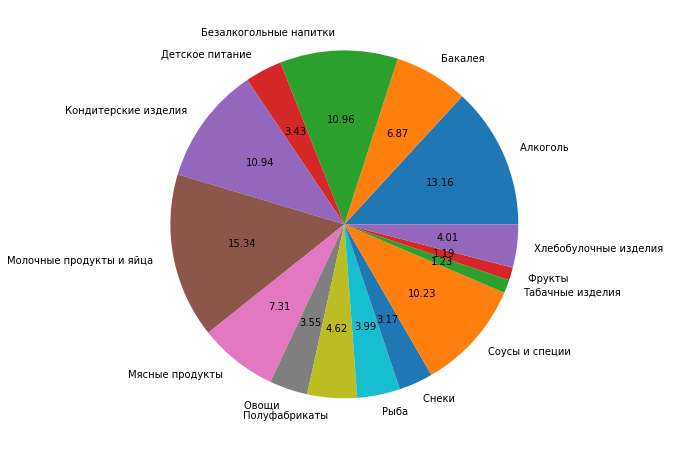

In [21]:
import matplotlib.pyplot as plt
viz = dataset.groupby(by = 'Category',as_index= False).agg({'Title':'count'})
plt.pie(viz['Title'],labels = viz['Category'],autopct='%.2f')
plt.rcParams["figure.figsize"] = (20,2)
plt.show()

In [15]:
viz

,Category,Title
0,Алкоголь,772
1,Бакалея,403
2,Безалкогольные напитки,643
3,Детское питание,201
4,Кондитерские изделия,642
5,Молочные продукты и яйца,900
6,Мясные продукты,429
7,Овощи,208
8,Полуфабрикаты,271
9,Рыба,234


In [22]:
viz2 = dataset.groupby(by = 'Country',as_index=False).agg({'Title':'count'})
viz2

,Country,Title
0,AM,19
1,AR,1
2,AU,10
3,BE,3
4,BY,94
5,CH,23
6,CL,3
7,CN,49
8,CU,6
9,DE,48


In [23]:
import geopandas
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter


geolocator = Nominatim(user_agent="viz2")
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)
viz2['location'] = viz2['Country'].apply(geocode)

RateLimiter caught an error, retrying (0/2 tries). Called with (*('IN',), **{}).
Traceback (most recent call last):
  File "C:\Users\Bakhtiyar\AppData\Roaming\Python\Python39\site-packages\urllib3\connectionpool.py", line 426, in _make_request
    six.raise_from(e, None)
  File "<string>", line 3, in raise_from
  File "C:\Users\Bakhtiyar\AppData\Roaming\Python\Python39\site-packages\urllib3\connectionpool.py", line 421, in _make_request
    httplib_response = conn.getresponse()
  File "c:\users\bakhtiyar\appdata\local\programs\python\python39\lib\http\client.py", line 1347, in getresponse
    response.begin()
  File "c:\users\bakhtiyar\appdata\local\programs\python\python39\lib\http\client.py", line 307, in begin
    version, status, reason = self._read_status()
  File "c:\users\bakhtiyar\appdata\local\programs\python\python39\lib\http\client.py", line 268, in _read_status
    line = str(self.fp.readline(_MAXLINE + 1), "iso-8859-1")
  File "c:\users\bakhtiyar\appdata\local\programs\pyt

RateLimiter swallowed an error after 2 retries. Called with (*('IN',), **{}).
Traceback (most recent call last):
  File "C:\Users\Bakhtiyar\AppData\Roaming\Python\Python39\site-packages\urllib3\connectionpool.py", line 426, in _make_request
    six.raise_from(e, None)
  File "<string>", line 3, in raise_from
  File "C:\Users\Bakhtiyar\AppData\Roaming\Python\Python39\site-packages\urllib3\connectionpool.py", line 421, in _make_request
    httplib_response = conn.getresponse()
  File "c:\users\bakhtiyar\appdata\local\programs\python\python39\lib\http\client.py", line 1347, in getresponse
    response.begin()
  File "c:\users\bakhtiyar\appdata\local\programs\python\python39\lib\http\client.py", line 307, in begin
    version, status, reason = self._read_status()
  File "c:\users\bakhtiyar\appdata\local\programs\python\python39\lib\http\client.py", line 268, in _read_status
    line = str(self.fp.readline(_MAXLINE + 1), "iso-8859-1")
  File "c:\users\bakhtiyar\appdata\local\programs\python

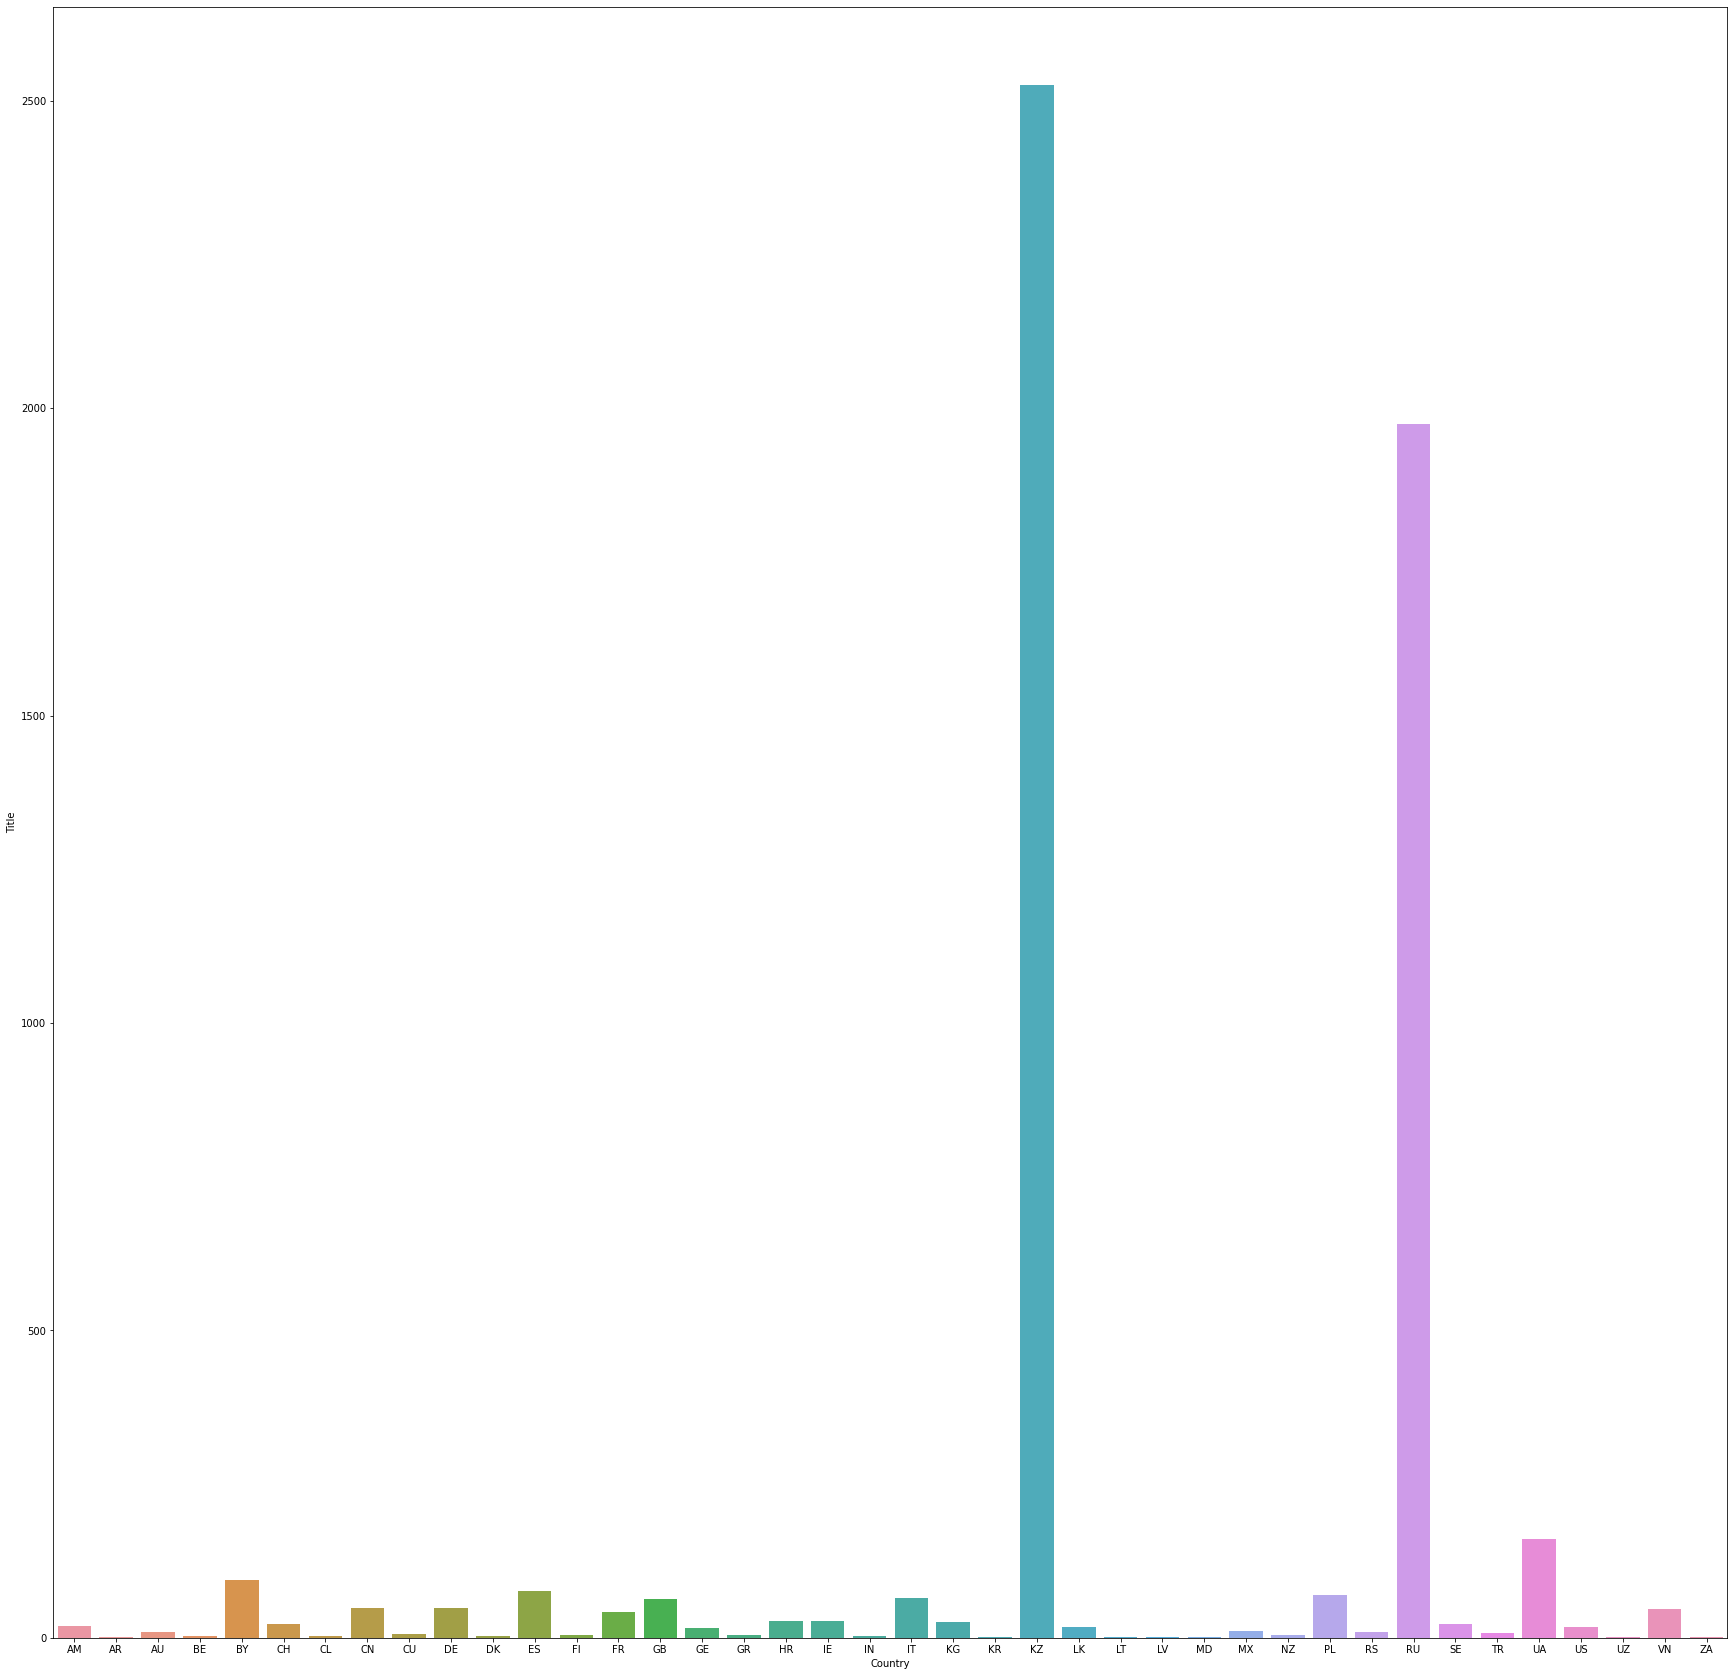

In [23]:
import seaborn as sns
sns.barplot(x=viz2['Country'],y = viz2['Title'])
plt.rcParams["figure.figsize"] = (15,30)
plt.show()